# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


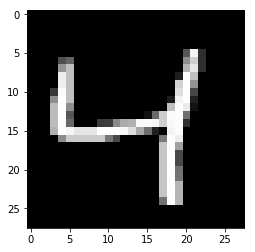

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [36]:
learning_rate = 0.001

# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1))
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1))

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=16, kernel_size=3, padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=8, kernel_size=2, padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=8, kernel_size=2, padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, pool_size=2, strides=2, padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_images(images=encoded, size=(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d_transpose(upsample1, filters=8, kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_images(images=conv4, size=(14, 14))
# Now 14x14x8
conv5 = tf.layers.conv2d_transpose(upsample2, filters=8, kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_images(images=conv5, size=(28, 28))
# Now 28x28x8
conv6 = tf.layers.conv2d_transpose(upsample3, filters=16, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d_transpose(conv6, filters=1, kernel_size=1, strides=1, padding='same', activation=None)
#Now 28x28x1
# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [37]:
sess = tf.Session()

In [38]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in tqdm_notebook(range(epochs)):
    for ii in tqdm_notebook(range(mnist.train.num_examples//batch_size), desc='training batch'):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.1922


Epoch: 2/20... Training loss: 0.1756


Epoch: 3/20... Training loss: 0.1649


Epoch: 4/20... Training loss: 0.1579


Epoch: 5/20... Training loss: 0.1535


Epoch: 6/20... Training loss: 0.1487


Epoch: 7/20... Training loss: 0.1472


Epoch: 8/20... Training loss: 0.1507


Epoch: 9/20... Training loss: 0.1472


Epoch: 10/20... Training loss: 0.1448


Epoch: 11/20... Training loss: 0.1407


Epoch: 12/20... Training loss: 0.1360


Epoch: 13/20... Training loss: 0.1404


Epoch: 14/20... Training loss: 0.1417


Epoch: 15/20... Training loss: 0.1340


Epoch: 16/20... Training loss: 0.1358


Epoch: 17/20... Training loss: 0.1316


Epoch: 18/20... Training loss: 0.1349


Epoch: 19/20... Training loss: 0.1342


Epoch: 20/20... Training loss: 0.1324



FailedPreconditionError: Attempting to use uninitialized value conv2d_24/kernel
	 [[Node: conv2d_24/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@conv2d_24/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](conv2d_24/kernel)]]
	 [[Node: Sigmoid_8/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_216_Sigmoid_8", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_24/kernel/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-428f87e7e4e5>", line 6, in <module>
    conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/convolutional.py", line 551, in conv2d
    return layer.apply(inputs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 492, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 434, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/convolutional.py", line 137, in build
    dtype=self.dtype)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 374, in add_variable
    trainable=trainable and self.trainable)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv2d_24/kernel
	 [[Node: conv2d_24/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@conv2d_24/kernel"], _device="/job:localhost/replica:0/task:0/gpu:0"](conv2d_24/kernel)]]
	 [[Node: Sigmoid_8/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_216_Sigmoid_8", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


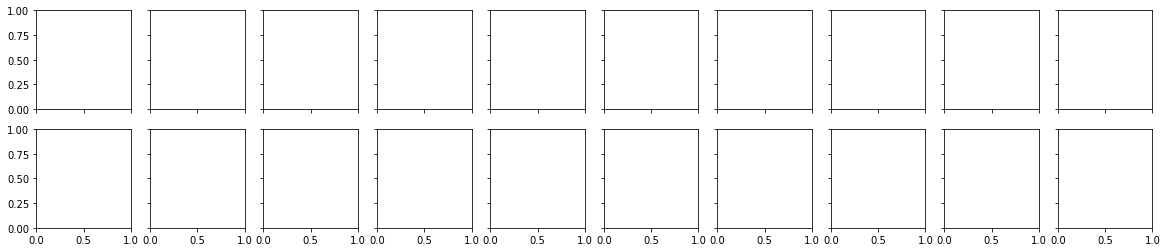

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [41]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [56]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2, padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=32, kernel_size=2, padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2, padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=16, kernel_size=2, padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, pool_size=2, strides=2, padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_images(images=encoded, size=(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d_transpose(upsample1, filters=16, kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_images(images=conv4, size=(14, 14))
# Now 14x14x16
conv5 = tf.layers.conv2d_transpose(upsample2, filters=32, kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_images(images=conv5, size=(28, 28))
# Now 28x28x32
conv6 = tf.layers.conv2d_transpose(upsample3, filters=16, kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d_transpose(conv6, filters=1, kernel_size=1, strides=1, padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [57]:
sess = tf.Session()

In [58]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in tqdm_notebook(range(epochs)):
    for ii in tqdm_notebook(range(mnist.train.num_examples//batch_size), desc='training epoch {}'.format(e), leave=False):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.2145


Epoch: 2/100... Training loss: 0.1955


Epoch: 3/100... Training loss: 0.1782


Epoch: 4/100... Training loss: 0.1763


Epoch: 5/100... Training loss: 0.1639


Epoch: 6/100... Training loss: 0.1624


Epoch: 7/100... Training loss: 0.1586


Epoch: 8/100... Training loss: 0.1585


Epoch: 9/100... Training loss: 0.1538


Epoch: 10/100... Training loss: 0.1461


Epoch: 11/100... Training loss: 0.1529


Epoch: 12/100... Training loss: 0.1454


Epoch: 13/100... Training loss: 0.1396


Epoch: 14/100... Training loss: 0.1370


Epoch: 15/100... Training loss: 0.1410


Epoch: 16/100... Training loss: 0.1401


Epoch: 17/100... Training loss: 0.1368


Epoch: 18/100... Training loss: 0.1372


Epoch: 19/100... Training loss: 0.1370


Epoch: 20/100... Training loss: 0.1373


Epoch: 21/100... Training loss: 0.1382


Epoch: 22/100... Training loss: 0.1359


Epoch: 23/100... Training loss: 0.1352


Epoch: 24/100... Training loss: 0.1318


Epoch: 25/100... Training loss: 0.1299


Epoch: 26/100... Training loss: 0.1345


Epoch: 27/100... Training loss: 0.1311


Epoch: 28/100... Training loss: 0.1268


Epoch: 29/100... Training loss: 0.1316


Epoch: 30/100... Training loss: 0.1366


Epoch: 31/100... Training loss: 0.1277


Epoch: 32/100... Training loss: 0.1292


Epoch: 33/100... Training loss: 0.1261


Epoch: 34/100... Training loss: 0.1346


Epoch: 35/100... Training loss: 0.1301


Epoch: 36/100... Training loss: 0.1289


Epoch: 37/100... Training loss: 0.1299


Epoch: 38/100... Training loss: 0.1257


Epoch: 39/100... Training loss: 0.1271


Epoch: 40/100... Training loss: 0.1276


Epoch: 41/100... Training loss: 0.1265


Epoch: 42/100... Training loss: 0.1313


Epoch: 43/100... Training loss: 0.1269


Epoch: 44/100... Training loss: 0.1257


Epoch: 45/100... Training loss: 0.1270


Epoch: 46/100... Training loss: 0.1287


Epoch: 47/100... Training loss: 0.1281


Epoch: 48/100... Training loss: 0.1279


Epoch: 49/100... Training loss: 0.1251


Epoch: 50/100... Training loss: 0.1249


Epoch: 51/100... Training loss: 0.1245


Epoch: 52/100... Training loss: 0.1259


Epoch: 53/100... Training loss: 0.1225


Epoch: 54/100... Training loss: 0.1198


Epoch: 55/100... Training loss: 0.1215


Epoch: 56/100... Training loss: 0.1277


Epoch: 57/100... Training loss: 0.1210


Epoch: 58/100... Training loss: 0.1227


Epoch: 59/100... Training loss: 0.1200


Epoch: 60/100... Training loss: 0.1262


Epoch: 61/100... Training loss: 0.1235


Epoch: 62/100... Training loss: 0.1282


Epoch: 63/100... Training loss: 0.1208


Epoch: 64/100... Training loss: 0.1255


Epoch: 65/100... Training loss: 0.1185


Epoch: 66/100... Training loss: 0.1245


Epoch: 67/100... Training loss: 0.1211


Epoch: 68/100... Training loss: 0.1214


Epoch: 69/100... Training loss: 0.1209


Epoch: 70/100... Training loss: 0.1209


Epoch: 71/100... Training loss: 0.1263


Epoch: 72/100... Training loss: 0.1211


Epoch: 73/100... Training loss: 0.1235


Epoch: 74/100... Training loss: 0.1189


Epoch: 75/100... Training loss: 0.1264


Epoch: 76/100... Training loss: 0.1233


Epoch: 77/100... Training loss: 0.1260


Epoch: 78/100... Training loss: 0.1206


Epoch: 79/100... Training loss: 0.1216


Epoch: 80/100... Training loss: 0.1177


Epoch: 81/100... Training loss: 0.1215


Epoch: 82/100... Training loss: 0.1226


Epoch: 83/100... Training loss: 0.1216


Epoch: 84/100... Training loss: 0.1208


Epoch: 85/100... Training loss: 0.1238


Epoch: 86/100... Training loss: 0.1238


Epoch: 87/100... Training loss: 0.1220


Epoch: 88/100... Training loss: 0.1183


Epoch: 89/100... Training loss: 0.1166


Epoch: 90/100... Training loss: 0.1214


Epoch: 91/100... Training loss: 0.1184


Epoch: 92/100... Training loss: 0.1186


Epoch: 93/100... Training loss: 0.1193


Epoch: 94/100... Training loss: 0.1186


Epoch: 95/100... Training loss: 0.1175


Epoch: 96/100... Training loss: 0.1208


Epoch: 97/100... Training loss: 0.1216


Epoch: 98/100... Training loss: 0.1233


Epoch: 99/100... Training loss: 0.1212


Epoch: 100/100... Training loss: 0.1196



## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

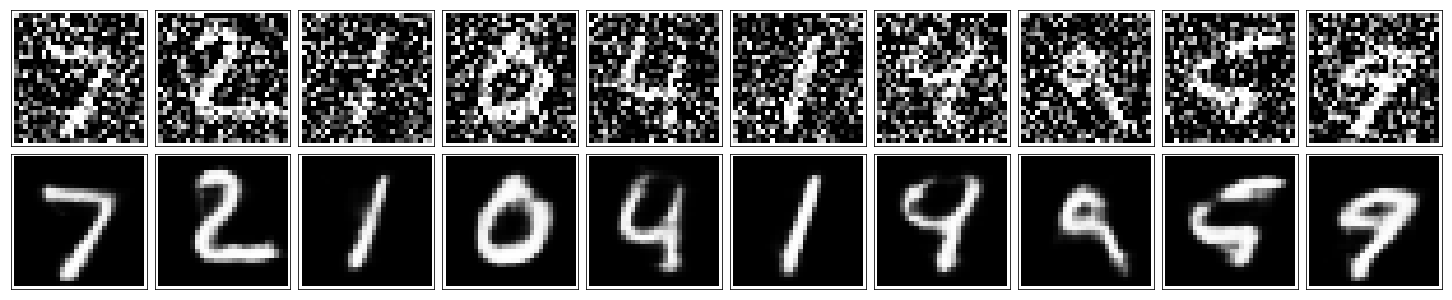

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [60]:
sess.close()